In [20]:
import os
import sys
import ast
import json
from collections import defaultdict
from matplotlib import pyplot as plt

import cv2
import numpy as np
import pandas as pd
import neuroglancer
from tqdm import tqdm
from skimage import io
import imagesize

sys.path.append(os.path.join(os.getcwd(), '../'))
from utilities.file_location import FileLocationManager
from utilities.sqlcontroller import SqlController
from utils import get_structure_number

In [2]:
animal = 'MD589'
downsample_factor = 16
all_structures = False

# OUTPUT_DIR_PATH = os.path.join(os.path.expanduser('~'))
OUTPUT_DIR_PATH = os.path.join('./')
CSV_DIR_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
IMAGE_DIR_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1/full'
    
sqlController = SqlController(animal)
resolution = sqlController.scan_run.resolution
aligned_shape = np.array((sqlController.scan_run.width, sqlController.scan_run.height))
num_section = len(os.listdir(IMAGE_DIR_PATH))

downsampled_aligned_shape = np.round(aligned_shape / downsample_factor).astype(int)
scales = np.array([resolution * downsample_factor, resolution * downsample_factor, 20]) * 1000

## Get the annotation points

In [7]:
csvfile = os.path.join(CSV_DIR_PATH, f'{animal}.formatted.structures.csv')
df = pd.read_csv(csvfile)
#csvoutfile = os.path.join(CSV_DIR_PATH, f'{animal}.formatted.structures.csv')
#df.to_csv(csvoutfile, index=False)
df['vertices'] = df['vertices'].apply(lambda x: ast.literal_eval(x))
structures = df['structure'].unique()
sections = df['section'].unique()
section_structure_vertices = defaultdict(dict)
for index, row in df.iterrows():
    SN = row['section']
    ST = row['structure']
    section_structure_vertices[SN][ST] = row['vertices']

In [36]:
#df[df["structure"] == "VCP"]
structures

array(['VCA', 'VCP', 'DC'], dtype=object)

In [9]:
c = 94
section_structure_vertices[94]

{'VCA': [[1631.0226507, 1055.65862063],
  [1637.02034793, 1052.65401951],
  [1644.01727787, 1048.64865169],
  [1650.01650911, 1047.64404999],
  [1658.01804075, 1049.6379134],
  [1663.02187428, 1054.63407693],
  [1667.02417411, 1057.63100805],
  [1670.02647422, 1060.62870616],
  [1671.02877493, 1063.62793828],
  [1671.03184293, 1067.62793711],
  [1665.03261169, 1068.63253881],
  [1657.03184705, 1067.6386751],
  [1650.03184911, 1067.6440441],
  [1644.03108387, 1066.6486464],
  [1637.02955193, 1064.65401599],
  [1631.0272527, 1061.65861887],
  [1631.0226507, 1055.65862063]]}

## Reproduce create_clean transform

In [173]:
section_offset = {}
for file_name in tqdm(sorted(os.listdir(IMAGE_DIR_PATH))):
    filepath = os.path.join(IMAGE_DIR_PATH, file_name)
    
    # Use imread is too slow for full res images
    width, height = imagesize.get(filepath)
    downsampled_shape = np.round(np.array((width, height)) / downsample_factor)
    
    section = int(file_name.split('.')[0])
    section_offset[section] = (downsampled_aligned_shape - downsampled_shape) // 2

100%|██████████| 56/56 [00:00<00:00, 69.66it/s]


In [174]:
section_offset[94]

array([600., 502.])

## Reproduce create_alignment transform

In [155]:
def parse_elastix_parameter_file(filepath):
    """
    Parse elastix parameter result file.
    """
    def parameter_elastix_parameter_file_to_dict(filename):
        d = {}
        with open(filename, 'r') as f:
            for line in f.readlines():
                if line.startswith('('):
                    tokens = line[1:-2].split(' ')
                    key = tokens[0]
                    if len(tokens) > 2:
                        value = []
                        for v in tokens[1:]:
                            try:
                                value.append(float(v))
                            except ValueError:
                                value.append(v)
                    else:
                        v = tokens[1]
                        try:
                            value = (float(v))
                        except ValueError:
                            value = v
                    d[key] = value
            return d

    d = parameter_elastix_parameter_file_to_dict(filepath)

    # For alignment composition script
    rot_rad, x_mm, y_mm = d['TransformParameters']
    center = np.array(d['CenterOfRotationPoint']) / np.array(d['Spacing'])
    # center[1] = d['Size'][1] - center[1]

    xshift = x_mm / d['Spacing'][0]
    yshift = y_mm / d['Spacing'][1]

    R = np.array([[np.cos(rot_rad), -np.sin(rot_rad)],
                  [np.sin(rot_rad), np.cos(rot_rad)]])
    shift = center + (xshift, yshift) - np.dot(R, center)
    T = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
    return T


def load_consecutive_section_transform(stack, moving_fn, fixed_fn):
    """
    Load pairwise transform.

    Returns:
        (3,3)-array.
    """
    assert stack is not None
    fileLocationManager = FileLocationManager(stack)
    elastix_output_dir = fileLocationManager.elastix_dir
    param_fp = os.path.join(elastix_output_dir, moving_fn + '_to_' + fixed_fn, 'TransformParameters.0.txt')
    #sys.stderr.write('Load elastix-computed transform: %s\n' % param_fp)
    if not os.path.exists(param_fp):
        raise Exception('Transform file does not exist: %s to %s, %s' % (moving_fn, fixed_fn, param_fp))
    transformation_to_previous_sec = parse_elastix_parameter_file(param_fp)

    return transformation_to_previous_sec

def parse_elastix(animal):
    """
    After the elastix job is done, this goes into each subdirectory and parses the Transformation.0.txt file
    Args:
        animal: the animal
    Returns: a dictionary of key=filename, value = coordinates
    """
    fileLocationManager = FileLocationManager(animal)
    DIR = fileLocationManager.prep
    INPUT = os.path.join(DIR, 'CH1', 'thumbnail_cleaned')

    image_name_list = sorted(os.listdir(INPUT))
    anchor_idx = len(image_name_list) // 2
    # anchor_idx = len(image_name_list) - 1
    transformation_to_previous_sec = {}

    for i in range(1, len(image_name_list)):
        fixed_fn = os.path.splitext(image_name_list[i - 1])[0]
        moving_fn = os.path.splitext(image_name_list[i])[0]
        transformation_to_previous_sec[i] = load_consecutive_section_transform(animal, moving_fn, fixed_fn)

    transformation_to_anchor_sec = {}
    # Converts every transformation
    for moving_idx in range(len(image_name_list)):
        if moving_idx == anchor_idx:
            transformation_to_anchor_sec[image_name_list[moving_idx]] = np.eye(3)
        elif moving_idx < anchor_idx:
            T_composed = np.eye(3)
            for i in range(anchor_idx, moving_idx, -1):
                T_composed = np.dot(np.linalg.inv(transformation_to_previous_sec[i]), T_composed)
            transformation_to_anchor_sec[image_name_list[moving_idx]] = T_composed
        else:
            T_composed = np.eye(3)
            for i in range(anchor_idx + 1, moving_idx + 1):
                T_composed = np.dot(transformation_to_previous_sec[i], T_composed)
            transformation_to_anchor_sec[image_name_list[moving_idx]] = T_composed

    return transformation_to_anchor_sec

def create_warp_transforms(transforms, downsample_factor=32):
    def convert_2d_transform_forms(arr):
        return np.vstack([arr, [0, 0, 1]])
    
    transforms_scale_factor = 32 / downsample_factor 
    tf_mat_mult_factor = np.array([[1, 1, transforms_scale_factor], [1, 1, transforms_scale_factor]])
    transforms_to_anchor = {}
    for img_name, tf in transforms.items():
        transforms_to_anchor[img_name] = convert_2d_transform_forms(np.reshape(tf, (3, 3))[:2] * tf_mat_mult_factor) 

    return transforms_to_anchor

transforms = parse_elastix(animal)
warp_transforms = create_warp_transforms(transforms, downsample_factor)
ordered_transforms = sorted(warp_transforms.items())

section_transform = {}
for section, transform in ordered_transforms:
    section_num = int(section.split('.')[0])
    transform = np.linalg.inv(transform)
    section_transform[section_num] = transform

## Alignment of annotation coordinates

In [180]:
'''
(x', y') = (x * sx + y * ry + tx, x * rx + y * sy + ty)
'sx': T[0, 0], 'sy': T[1, 1], 'rx': T[1, 0], 'ry': T[0, 1], 'tx': T[0, 2], 'ty': T[1, 2]
'''
def transform_create_alignment(points, transform):
    a = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.T[:, 0:2]
    c = np.matmul(a, b)
    return c

aligned_section_structure_polygons = defaultdict(dict)
for section in section_structure_vertices:
    for structure in section_structure_vertices[section]:
        points = np.array(section_structure_vertices[section][structure]) // downsample_factor
        points = points + section_offset[section] # create_clean offset
        points = transform_create_alignment(points, section_transform[section]) # create_alignment transform
        aligned_section_structure_polygons[section][structure] = [points]

In [ ]:
import pickle

vertices_path = os.path.join(OUTPUT_DIR_PATH, f'{animal}_aligned_section_structure_polygons_down{downsample_factor}.pickle')
with open(vertices_path, 'wb') as file:
    pickle.dump(aligned_section_structure_polygons, file)

To this point, aligned_section_structure_polygons variable contains the aligned polygon vertices for each structure in each section. 
From now on, we introduce how to draw these points to numpy array or neuroglancer

In [163]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 2
thickness = 5
colors = {}
colors['DC'] = (0,0,0)
colors['VCA'] = (255,0,0)
colors['VCP'] = (255,0,255)
#'VCA', 'VCP', 'DC'
unpad = lambda x: x[:, :-1]

PATH = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD589/preps/CH1'
DOWN16 = os.path.join(PATH, 'downsample_16')
ALIGNED = os.path.join(PATH, 'downsample_16_aligned')

VCA 103 with offset 1645.1612903225807 1059.516129032258
VCP 103 with offset 1713.111111111111 1085.5
img shape (2025, 2731, 3)


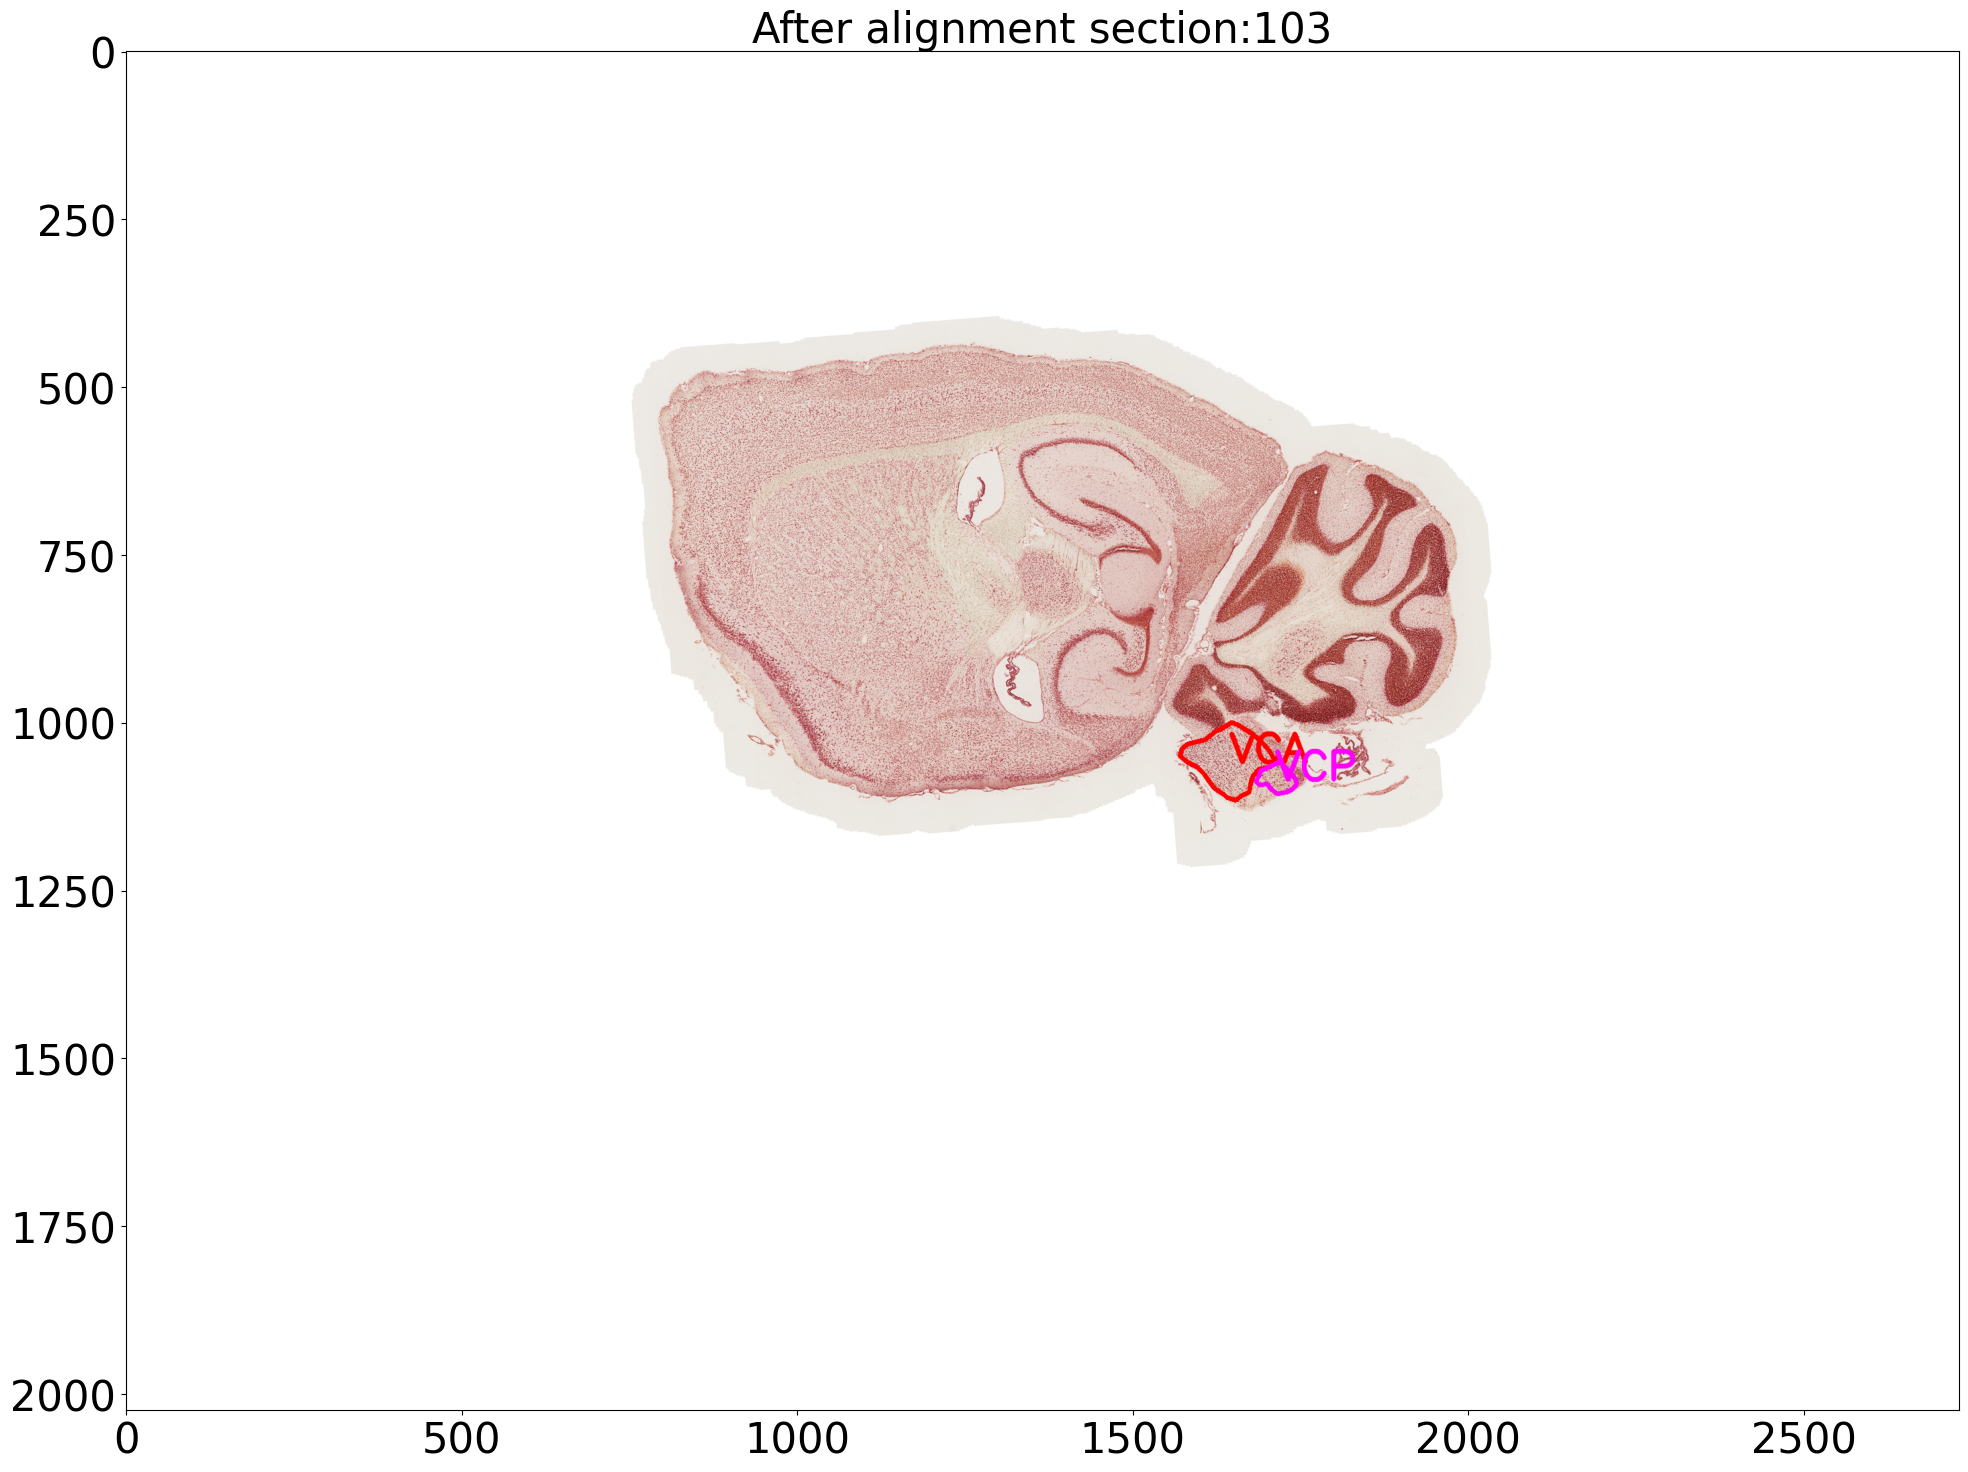

In [209]:
file_name = '103.tif'
filepath = os.path.join(ALIGNED, file_name)
img = cv2.imread(filepath)
section = int(file_name.split('.')[0])

for structure in section_structure_vertices[section]:
    pts = section_structure_vertices[section][structure]
    points = np.array(pts, dtype=np.int32) 
    cx, cy = np.mean(points, axis=0)
    print(structure,section,'with offset',cx,cy)
    cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=5)
    cv2.putText(img, structure, (int(cx),int(cy)), font,
                fontScale, colors[structure], thickness, cv2.LINE_AA)

print('img shape', img.shape)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
#fig.suptitle('test title', fontsize=20)
plt.imshow(img, cmap="gray")
plt.title('After alignment section:{}'.format(section), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

VCA 103 with centers 1035.0 709.8064516129032 offset [558. 431.]
VCP 103 with centers 1100.888888888889 741.1666666666666 offset [558. 431.]


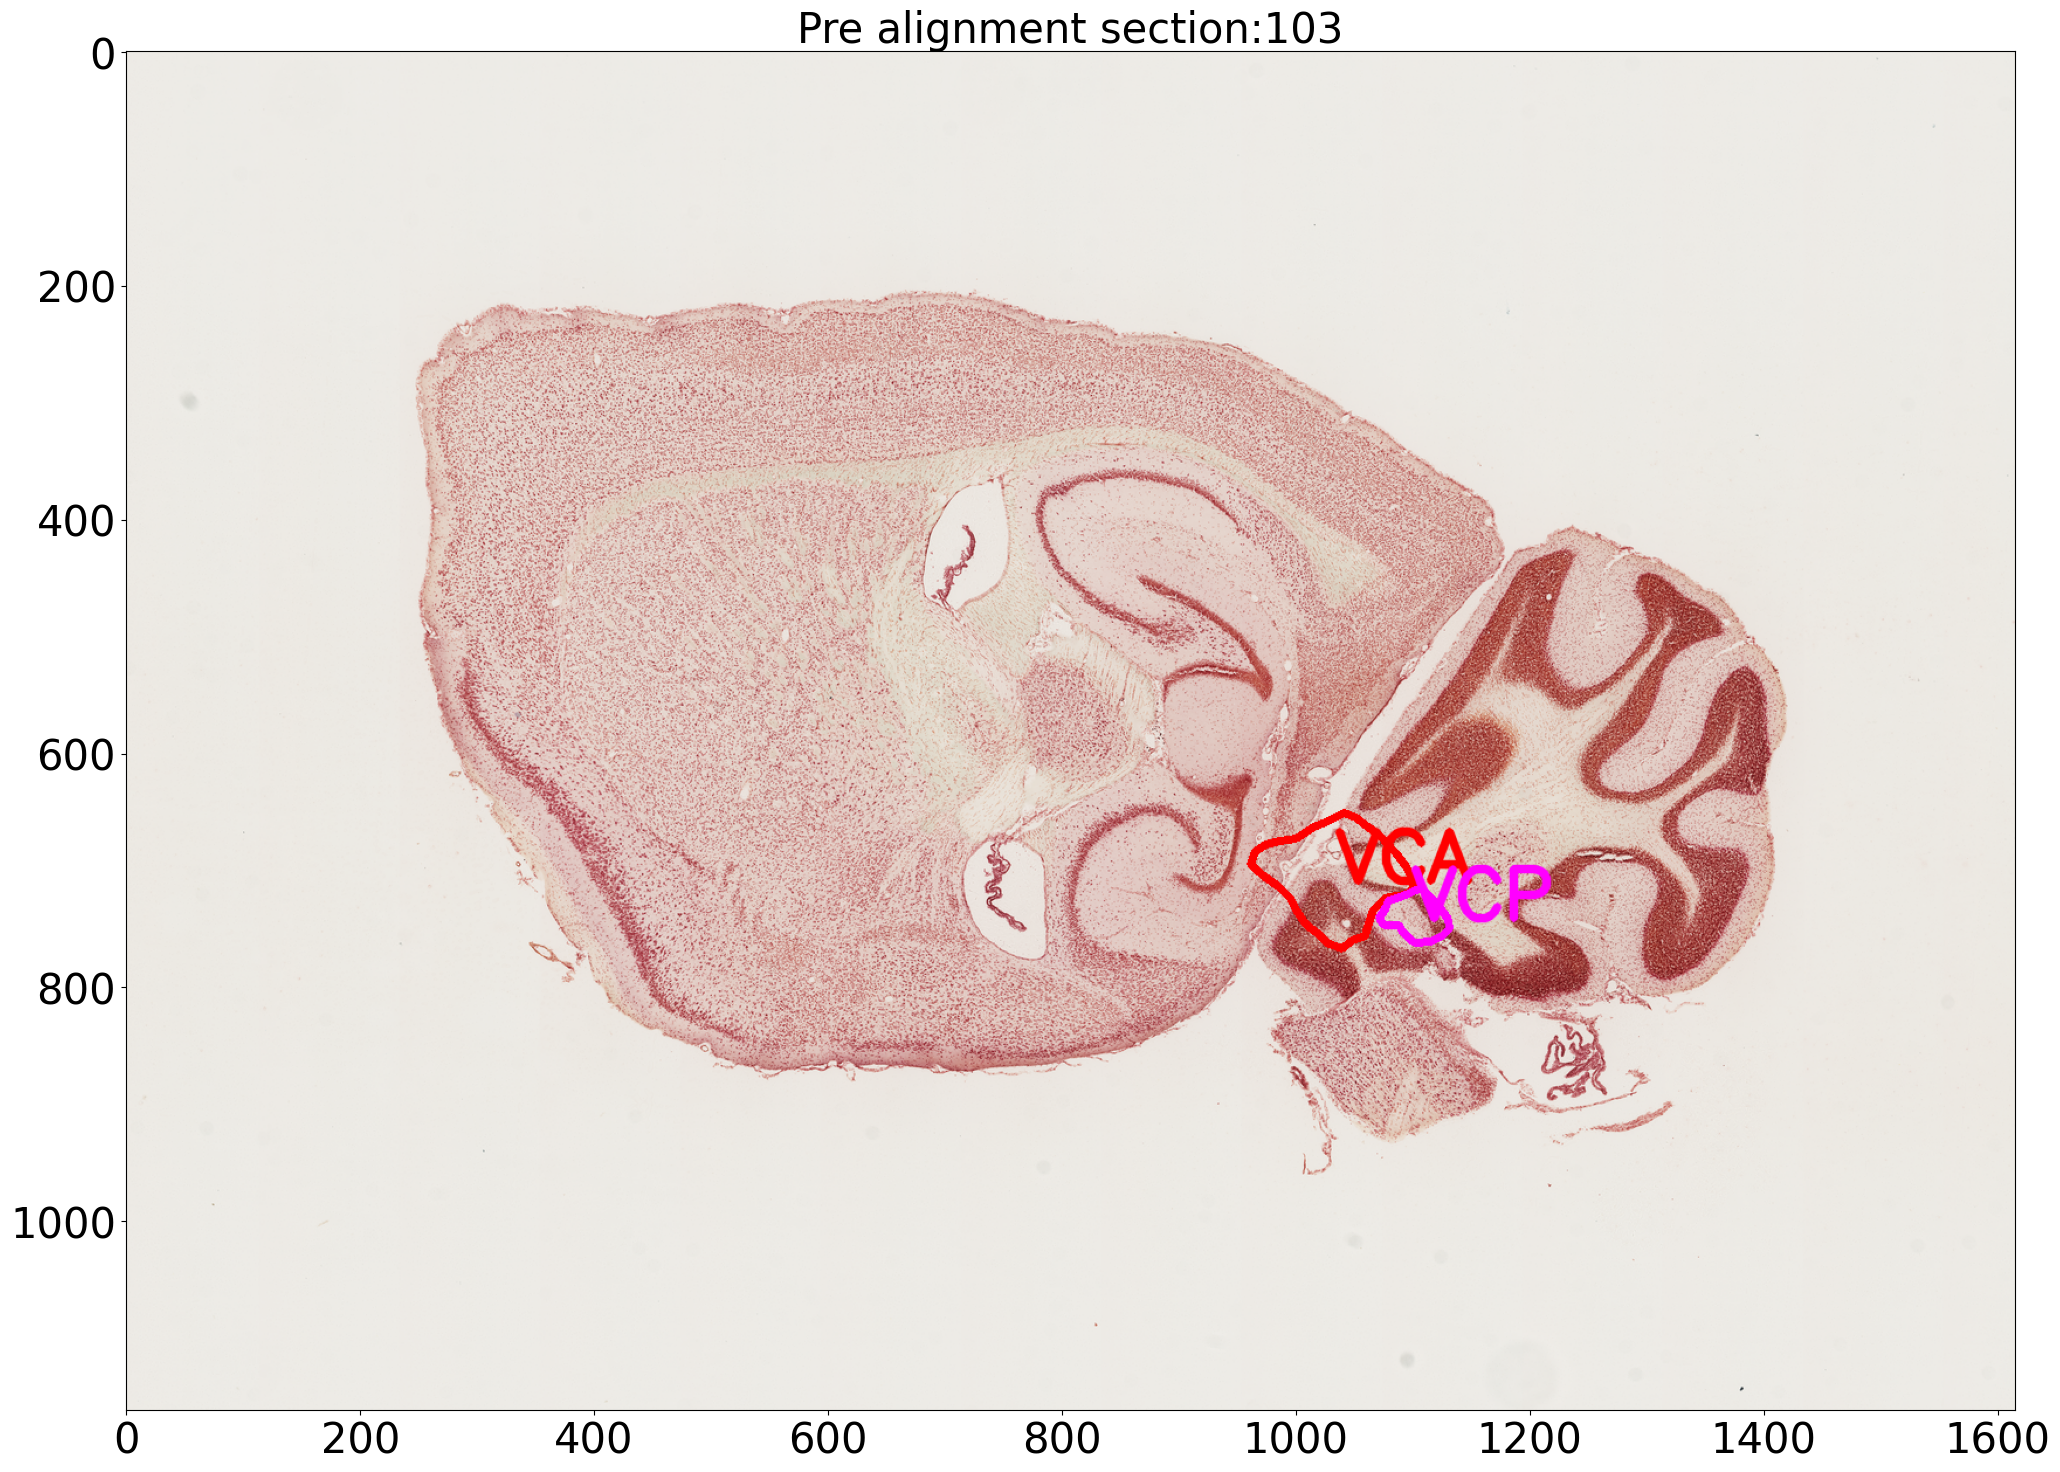

In [211]:
file_name = '103.tif'
filepath = os.path.join(DOWN16, file_name)
img = cv2.imread(filepath)
section = int(file_name.split('.')[0])

for structure in section_structure_vertices[section]:
    pts = section_structure_vertices[section][structure]
    points = np.array(pts, dtype=np.int32) 
    offset = section_offset[section]
    transform = section_transform[section]
    t00 = transform[0][0]
    t01 = transform[0][1]
    t10 = transform[1][0]
    t11 = transform[1][1]
    R = np.array([[t00, t01],[t10, t11]])
    points = np.dot(points-offset, R).astype(np.int32)
    cx, cy = np.mean(points, axis=0)
    print(structure,section,'with centers',cx,cy, 'offset', offset)
    cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=5)
    cv2.putText(img, structure, (int(cx),int(cy)), font,
                fontScale, colors[structure], thickness, cv2.LINE_AA)

fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Pre alignment section:{}'.format(section), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

# Fill up a pandas dataframe with the corrected vertices and save it.

In [216]:
data = []
files = sorted(os.listdir(DOWN16))
for file_name in files:
    filepath = os.path.join(DOWN16, file_name)
    img = cv2.imread(filepath)
    section = int(file_name.split('.')[0])
    
    if section in section_structure_vertices:
        for structure in section_structure_vertices[section]:
            pts = section_structure_vertices[section][structure]
            points = np.array(pts, dtype=np.int32)
            #print(structure, section, points.shape)
            # Litao, put in proper transformation here
            data.append([structure, section, points])
            
df = pd.DataFrame(data=data, columns=['structure', 'section', 'vertices'])
df.head()
outpath = os.path.join(CSV_DIR_PATH, f'{animal}_corrected_vertices.csv')
df.to_csv(outpath, index=False)